In [13]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


# Data preparation

label
other              44
meniskus_urgent    39
cruciate_urgent     9
meniskus_low        7
other_urgent        1
Name: count, dtype: int64


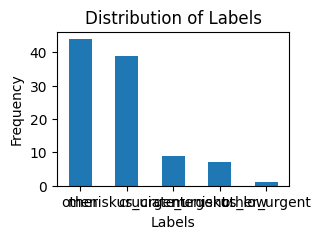

In [14]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/balanced_classification_dataset.csv').head(100)
df_valid = pd.read_csv('../data/balanced_classification_dataset.csv').head(100)
df_test = pd.read_csv('../data/balanced_classification_dataset.csv').head(100)

train_padded, valid_padded, test_padded, train_labels, valid_labels, test_labels, label_encoder, num_classes, max_length, word_index, class_weights, sample_weights = process_train_test_data(df_train, df_valid, df_test, data_label, predict_label, lables=labels, class_weights=class_weights, sample_weights=sample_weights)

# Model parameters

In [15]:
embedding_dim = 300
lstm_units = 64
epochs = 10
batch_size = 32
model_name = "test"

In [16]:
optimizer = Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
metrics=[
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.F1Score(average="macro", name='f1_score'),
]
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  
    patience=3,         
    restore_best_weights=True,
    verbose=1
)

# Model definition and training

In [17]:
# Define the input layer
input_text = Input(shape=(max_length,), dtype='int32', name='text_input')

# Embedding layer
embedding = Embedding(input_dim=len(word_index), output_dim=embedding_dim)(input_text)

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(embedding)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(embedding)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
history = model.fit(train_padded, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(valid_padded, valid_labels), callbacks=[early_stopping_callback])

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.3379 - auc: 0.7165 - f1_score: 0.1463 - loss: 1.5404 - val_accuracy: 0.6900 - val_auc: 0.8921 - val_f1_score: 0.2983 - val_loss: 1.2912
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.5837 - auc: 0.8547 - f1_score: 0.2364 - loss: 1.2501 - val_accuracy: 0.4400 - val_auc: 0.8596 - val_f1_score: 0.1222 - val_loss: 1.1477
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4135 - auc: 0.8383 - f1_score: 0.1168 - loss: 1.1913 - val_accuracy: 0.4600 - val_auc: 0.8540 - val_f1_score: 0.1435 - val_loss: 1.0928
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5455 - auc: 0.8607 - f1_score: 0.2114 - loss: 1.0783 - val_accuracy: 0.7000 - val_auc: 0.8947 - val_f1_score: 0.3061 - val_loss: 1.0313
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.7265 - auc: 0.9116 - f1_score: 0.3144 - loss: 0.9593 - val_accuracy: 0.6900 - val_auc: 0.8948 - val_f1_score: 0.3031 - val_loss: 0.9715
Epoc

In [19]:
save_for_evaluation(model, history, model_name, test_padded, test_labels, label_encoder)

Model saved to models/test/test.h5
Data saved


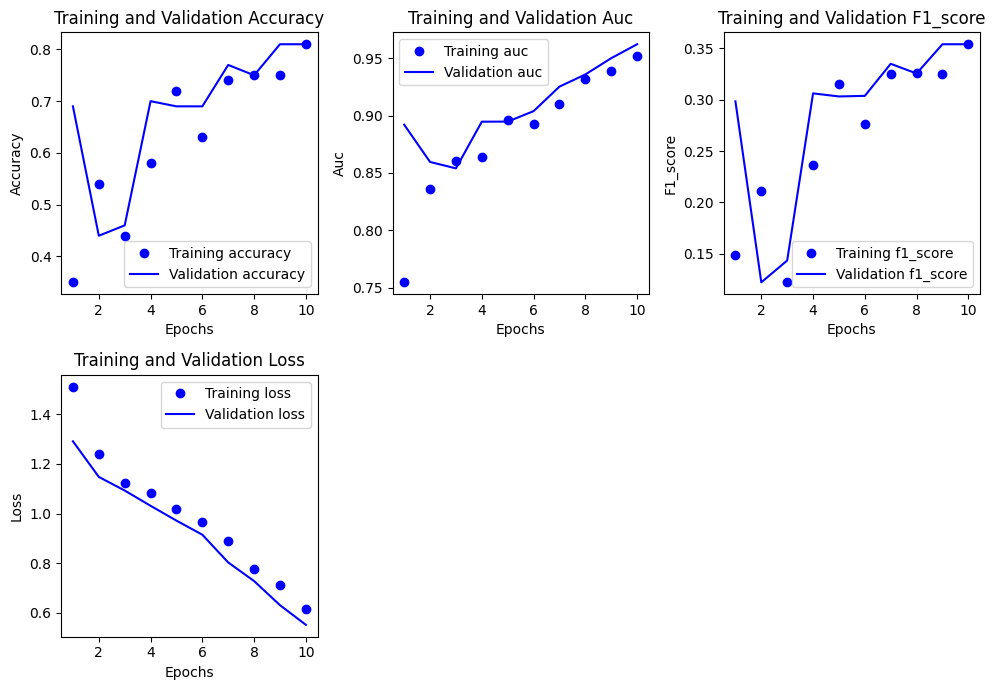

In [20]:
eval_training(history, metrics)

In [21]:
eval(model, test_padded, test_labels, label_encoder)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
{'cruciate_urgent': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 9.0}, 'meniskus_low': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 7.0}, 'meniskus_urgent': {'precision': 0.7115384615384616, 'recall': 0.9487179487179487, 'f1-score': 0.8131868131868132, 'support': 39.0}, 'other': {'precision': 0.9166666666666666, 'recall': 1.0, 'f1-score': 0.9565217391304348, 'support': 44.0}, 'other_urgent': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'accuracy': 0.81, 'macro avg': {'precision': 0.32564102564102565, 'recall': 0.38974358974358975, 'f1-score': 0.3539417104634496, 'support': 100.0}, 'weighted avg': {'precision': 0.6808333333333333, 'recall': 0.81, 'f1-score': 0.7380124223602484, 'support': 100.0}}


/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av